In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DConditionModel, AutoencoderKL
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
from sentence_transformers import SentenceTransformer
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# class EmojiDataset(Dataset):
#     def __init__(self, parquet_file, transform=None):
#         self.data = pd.read_parquet(parquet_file)
#         self.transform = transform
class EmojiDataset(Dataset):
    def __init__(self, parquet_file, sample_size=500, transform=None):
        self.data = pd.read_parquet(parquet_file).sample(n=sample_size, random_state=42)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]["image_path"]
        image_tensor = torch.load(image_path)  # Shape: (3, 64, 64)
        image_tensor = image_tensor.float() / 255.0 * 2 - 1  # Normalize to [-1,1]

        text_embedding = torch.tensor(self.data.iloc[idx]["combined_embedding"], dtype=torch.float32)

        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, text_embedding

In [3]:
# Load Dataset
parquet_file = "../data/processed_emoji_dataset.parquet"
dataset = EmojiDataset(parquet_file)
batch_size = 32  # Reduce batch size to prevent GPU crash
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Load Stable Diffusion VAE and UNet
vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2", subfolder="vae").to("cuda")
unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2", subfolder="unet").to("cuda")

In [5]:
# Enable memory optimization
unet.enable_gradient_checkpointing()  # Saves memory

In [6]:
# Embedding Projector (SBERT 384 → UNet Expected 768)
class EmbeddingProjector(nn.Module):
    def __init__(self, input_dim=384, output_dim=1024):  # Correct output size
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)  # SBERT 384 → UNet 768

    def forward(self, x):
        return self.fc(x)

embedding_projector = EmbeddingProjector().to("cuda")



In [7]:
# Freeze all UNet layers first
for param in unet.parameters():
    param.requires_grad = False  

# Unfreeze only the last N layers (adjust as needed)
num_layers_to_train = 2  # Change as needed
for module in list(unet.children())[-num_layers_to_train:]:  
    for param in module.parameters():
        param.requires_grad = True  

# Freeze VAE (it only encodes/decodes, doesn't need training)
for param in vae.parameters():
    param.requires_grad = False  

# Reinitialize optimizer with only trainable parameters
optimizer = AdamW(filter(lambda p: p.requires_grad, unet.parameters()), lr=1e-4)
scaler = torch.amp.GradScaler()

In [8]:
num_epochs = 100
losses = []  # Store loss for plotting

# Training Loop with tqdm
for epoch in range(num_epochs):
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for images, embeddings in progress_bar:
        images, embeddings = images.to("cuda"), embeddings.to("cuda")

        optimizer.zero_grad()

        # Project SBERT embeddings to match UNet's expected input size
        with torch.no_grad():
            projected_embeddings = embedding_projector(embeddings).unsqueeze(1)  # (batch_size, 1, 768)

        # Encode images into latent space
        # Encode images into latent space
        
        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample()  # Shape: (batch, 4, 64, 64)
            latents = latents * 0.18215  # Scaling used in Stable Diffusion
            latents = F.interpolate(latents, size=(8, 8), mode="bilinear", align_corners=False)  # Resize to 8×8

        # with torch.no_grad():
        #     latents = vae.encode(images).latent_dist.sample()  # Shape: (batch, 4, 64, 64)
        #     latents = latents * 0.18215  # Scaling used in Stable Diffusion

        # Generate random noise
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device="cuda").long()

        with torch.amp.autocast("cuda"):
            noise_pred = unet(latents, timesteps, encoder_hidden_states=projected_embeddings).sample
            loss = F.mse_loss(noise_pred, noise)

        # Backpropagate with Mixed Precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())  # Update tqdm bar

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

# Clear Memory
torch.cuda.empty_cache()

# Save Model
torch.save({
    "unet": unet.state_dict(),
    "embedding_projector": embedding_projector.state_dict()
}, "emoji_generator.pth")

print("Model saved successfully!")




Epoch 1/100: 100%|██████████| 16/16 [00:02<00:00,  5.33it/s, loss=2.21]


Epoch 1/100, Loss: 2.2742


Epoch 2/100: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s, loss=1.68]


Epoch 2/100, Loss: 1.8385


Epoch 3/100: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, loss=1.53]


Epoch 3/100, Loss: 1.5858


Epoch 4/100: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=1.39]


Epoch 4/100, Loss: 1.3955


Epoch 5/100: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss=1.23]


Epoch 5/100, Loss: 1.2852


Epoch 6/100: 100%|██████████| 16/16 [00:02<00:00,  5.88it/s, loss=1.18]


Epoch 6/100, Loss: 1.2002


Epoch 7/100: 100%|██████████| 16/16 [00:02<00:00,  6.01it/s, loss=1.15]


Epoch 7/100, Loss: 1.1574


Epoch 8/100: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s, loss=1.13]


Epoch 8/100, Loss: 1.1329


Epoch 9/100: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=1.04]


Epoch 9/100, Loss: 1.1040


Epoch 10/100: 100%|██████████| 16/16 [00:02<00:00,  5.85it/s, loss=1.11]


Epoch 10/100, Loss: 1.1003


Epoch 11/100: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s, loss=1.12]


Epoch 11/100, Loss: 1.0929


Epoch 12/100: 100%|██████████| 16/16 [00:02<00:00,  6.07it/s, loss=1.08]


Epoch 12/100, Loss: 1.0903


Epoch 13/100: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, loss=1.11]


Epoch 13/100, Loss: 1.0844


Epoch 14/100: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, loss=1.12]


Epoch 14/100, Loss: 1.0763


Epoch 15/100: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss=1.08]


Epoch 15/100, Loss: 1.0776


Epoch 16/100: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s, loss=1.05]


Epoch 16/100, Loss: 1.0696


Epoch 17/100: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s, loss=1.08]


Epoch 17/100, Loss: 1.0703


Epoch 18/100: 100%|██████████| 16/16 [05:37<00:00, 21.07s/it, loss=1.08]


Epoch 18/100, Loss: 1.0713


Epoch 19/100: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss=1.07]


Epoch 19/100, Loss: 1.0750


Epoch 20/100: 100%|██████████| 16/16 [00:02<00:00,  6.49it/s, loss=1.06]


Epoch 20/100, Loss: 1.0695


Epoch 21/100: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss=1.09]


Epoch 21/100, Loss: 1.0653


Epoch 22/100: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s, loss=1.07]


Epoch 22/100, Loss: 1.0546


Epoch 23/100: 100%|██████████| 16/16 [00:02<00:00,  5.58it/s, loss=1.08]


Epoch 23/100, Loss: 1.0681


Epoch 24/100: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=1.09]


Epoch 24/100, Loss: 1.0630


Epoch 25/100: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s, loss=1.07]


Epoch 25/100, Loss: 1.0542


Epoch 26/100: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s, loss=1.05]


Epoch 26/100, Loss: 1.0596


Epoch 27/100: 100%|██████████| 16/16 [00:02<00:00,  6.01it/s, loss=1.04]


Epoch 27/100, Loss: 1.0497


Epoch 28/100: 100%|██████████| 16/16 [00:02<00:00,  6.01it/s, loss=1.07]


Epoch 28/100, Loss: 1.0522


Epoch 29/100: 100%|██████████| 16/16 [00:02<00:00,  5.77it/s, loss=1.11]


Epoch 29/100, Loss: 1.0585


Epoch 30/100: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, loss=1.05]


Epoch 30/100, Loss: 1.0532


Epoch 31/100: 100%|██████████| 16/16 [00:03<00:00,  4.15it/s, loss=1.04]


Epoch 31/100, Loss: 1.0480


Epoch 32/100: 100%|██████████| 16/16 [00:03<00:00,  4.79it/s, loss=1.05]


Epoch 32/100, Loss: 1.0556


Epoch 33/100: 100%|██████████| 16/16 [00:03<00:00,  4.18it/s, loss=1.06]


Epoch 33/100, Loss: 1.0529


Epoch 34/100: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s, loss=1.06]


Epoch 34/100, Loss: 1.0510


Epoch 35/100: 100%|██████████| 16/16 [00:03<00:00,  4.51it/s, loss=1.06]


Epoch 35/100, Loss: 1.0551


Epoch 36/100: 100%|██████████| 16/16 [00:03<00:00,  4.44it/s, loss=1.03]


Epoch 36/100, Loss: 1.0466


Epoch 37/100: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it, loss=1.02]


Epoch 37/100, Loss: 1.0400


Epoch 38/100: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, loss=1.06]


Epoch 38/100, Loss: 1.0423


Epoch 39/100: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, loss=1.06]


Epoch 39/100, Loss: 1.0430


Epoch 40/100: 100%|██████████| 16/16 [00:02<00:00,  5.84it/s, loss=1.06]


Epoch 40/100, Loss: 1.0492


Epoch 41/100: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s, loss=1.06]


Epoch 41/100, Loss: 1.0355


Epoch 42/100: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s, loss=1]   


Epoch 42/100, Loss: 1.0356


Epoch 43/100: 100%|██████████| 16/16 [00:03<00:00,  4.60it/s, loss=1.03]


Epoch 43/100, Loss: 1.0400


Epoch 44/100: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s, loss=1.03]


Epoch 44/100, Loss: 1.0386


Epoch 45/100: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s, loss=1.05]


Epoch 45/100, Loss: 1.0440


Epoch 46/100: 100%|██████████| 16/16 [00:03<00:00,  4.66it/s, loss=1.06]


Epoch 46/100, Loss: 1.0411


Epoch 47/100: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, loss=1.02]


Epoch 47/100, Loss: 1.0435


Epoch 48/100: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s, loss=1.04]


Epoch 48/100, Loss: 1.0384


Epoch 49/100: 100%|██████████| 16/16 [00:03<00:00,  5.26it/s, loss=1.03]


Epoch 49/100, Loss: 1.0361


Epoch 50/100: 100%|██████████| 16/16 [00:02<00:00,  6.40it/s, loss=1.02]


Epoch 50/100, Loss: 1.0315


Epoch 51/100: 100%|██████████| 16/16 [00:02<00:00,  6.04it/s, loss=1.06]


Epoch 51/100, Loss: 1.0412


Epoch 52/100: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s, loss=1.05]


Epoch 52/100, Loss: 1.0385


Epoch 53/100: 100%|██████████| 16/16 [00:02<00:00,  6.60it/s, loss=1.03]


Epoch 53/100, Loss: 1.0327


Epoch 54/100: 100%|██████████| 16/16 [00:02<00:00,  6.31it/s, loss=1.07]


Epoch 54/100, Loss: 1.0349


Epoch 55/100: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s, loss=1.02]


Epoch 55/100, Loss: 1.0285


Epoch 56/100: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s, loss=1.04]


Epoch 56/100, Loss: 1.0381


Epoch 57/100: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s, loss=1.02]


Epoch 57/100, Loss: 1.0305


Epoch 58/100: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s, loss=1.04]


Epoch 58/100, Loss: 1.0401


Epoch 59/100: 100%|██████████| 16/16 [00:04<00:00,  3.79it/s, loss=1.04]


Epoch 59/100, Loss: 1.0415


Epoch 60/100: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s, loss=1.02]


Epoch 60/100, Loss: 1.0293


Epoch 61/100: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s, loss=1]   


Epoch 61/100, Loss: 1.0233


Epoch 62/100: 100%|██████████| 16/16 [00:02<00:00,  6.63it/s, loss=1.04]


Epoch 62/100, Loss: 1.0291


Epoch 63/100: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s, loss=1.05]


Epoch 63/100, Loss: 1.0414


Epoch 64/100: 100%|██████████| 16/16 [00:02<00:00,  5.71it/s, loss=1.04]


Epoch 64/100, Loss: 1.0253


Epoch 65/100: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss=1.01]


Epoch 65/100, Loss: 1.0278


Epoch 66/100: 100%|██████████| 16/16 [00:03<00:00,  5.27it/s, loss=1.03]


Epoch 66/100, Loss: 1.0382


Epoch 67/100: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s, loss=1.08]


Epoch 67/100, Loss: 1.0320


Epoch 68/100: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s, loss=1.04]


Epoch 68/100, Loss: 1.0264


Epoch 69/100: 100%|██████████| 16/16 [00:02<00:00,  5.97it/s, loss=1.02]


Epoch 69/100, Loss: 1.0288


Epoch 70/100: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s, loss=1.02]


Epoch 70/100, Loss: 1.0252


Epoch 71/100: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s, loss=1.01] 


Epoch 71/100, Loss: 1.0323


Epoch 72/100: 100%|██████████| 16/16 [00:02<00:00,  5.71it/s, loss=1.01]


Epoch 72/100, Loss: 1.0274


Epoch 73/100: 100%|██████████| 16/16 [00:07<00:00,  2.28it/s, loss=1.02]


Epoch 73/100, Loss: 1.0273


Epoch 74/100: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s, loss=1.01]


Epoch 74/100, Loss: 1.0276


Epoch 75/100: 100%|██████████| 16/16 [00:08<00:00,  1.83it/s, loss=1.05]


Epoch 75/100, Loss: 1.0337


Epoch 76/100: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s, loss=1.05]


Epoch 76/100, Loss: 1.0318


Epoch 77/100: 100%|██████████| 16/16 [00:02<00:00,  6.38it/s, loss=1.05] 


Epoch 77/100, Loss: 1.0279


Epoch 78/100: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss=1.03]


Epoch 78/100, Loss: 1.0264


Epoch 79/100: 100%|██████████| 16/16 [00:02<00:00,  5.68it/s, loss=1]   


Epoch 79/100, Loss: 1.0303


Epoch 80/100: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s, loss=1.01]


Epoch 80/100, Loss: 1.0299


Epoch 81/100: 100%|██████████| 16/16 [00:03<00:00,  4.54it/s, loss=1.04]


Epoch 81/100, Loss: 1.0276


Epoch 82/100: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s, loss=1.01]


Epoch 82/100, Loss: 1.0164


Epoch 83/100: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s, loss=1.03]


Epoch 83/100, Loss: 1.0248


Epoch 84/100: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s, loss=0.993]


Epoch 84/100, Loss: 1.0201


Epoch 85/100: 100%|██████████| 16/16 [00:03<00:00,  4.01it/s, loss=1.03]


Epoch 85/100, Loss: 1.0209


Epoch 86/100: 100%|██████████| 16/16 [00:06<00:00,  2.29it/s, loss=1.02]


Epoch 86/100, Loss: 1.0226


Epoch 87/100: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s, loss=1]    


Epoch 87/100, Loss: 1.0228


Epoch 88/100: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, loss=0.992]


Epoch 88/100, Loss: 1.0205


Epoch 89/100: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss=1.06]


Epoch 89/100, Loss: 1.0254


Epoch 90/100: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s, loss=1.02]


Epoch 90/100, Loss: 1.0219


Epoch 91/100: 100%|██████████| 16/16 [00:02<00:00,  5.97it/s, loss=0.99] 


Epoch 91/100, Loss: 1.0251


Epoch 92/100: 100%|██████████| 16/16 [00:02<00:00,  5.86it/s, loss=1.02] 


Epoch 92/100, Loss: 1.0264


Epoch 93/100: 100%|██████████| 16/16 [00:02<00:00,  5.91it/s, loss=1.04] 


Epoch 93/100, Loss: 1.0196


Epoch 94/100: 100%|██████████| 16/16 [00:02<00:00,  5.74it/s, loss=1.02] 


Epoch 94/100, Loss: 1.0162


Epoch 95/100: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s, loss=1.03]


Epoch 95/100, Loss: 1.0236


Epoch 96/100: 100%|██████████| 16/16 [00:02<00:00,  5.81it/s, loss=1]    


Epoch 96/100, Loss: 1.0180


Epoch 97/100: 100%|██████████| 16/16 [00:02<00:00,  5.60it/s, loss=1.03]


Epoch 97/100, Loss: 1.0250


Epoch 98/100: 100%|██████████| 16/16 [00:02<00:00,  5.59it/s, loss=0.988]


Epoch 98/100, Loss: 1.0190


Epoch 99/100: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s, loss=1.02]


Epoch 99/100, Loss: 1.0186


Epoch 100/100: 100%|██████████| 16/16 [00:02<00:00,  5.91it/s, loss=1.04] 


Epoch 100/100, Loss: 1.0152
Model saved successfully!


In [9]:
# Save Model
torch.save({
    "unet": unet.state_dict(),
    "embedding_projector": embedding_projector.state_dict()
}, "emoji_generator.pth")

print("Model saved successfully!")

Model saved successfully!


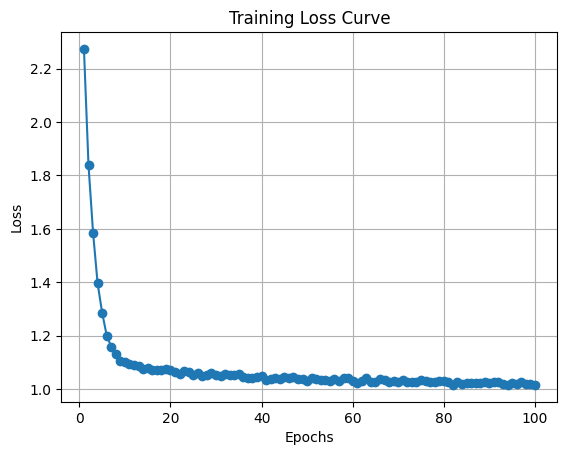

In [10]:
# Plot Loss Curve
plt.plot(range(1, num_epochs + 1), losses, marker="o", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

In [11]:
# Load the trained model
checkpoint = torch.load("emoji_generator.pth")
unet.load_state_dict(checkpoint["unet"])
embedding_projector.load_state_dict(checkpoint["embedding_projector"])
unet.eval()
embedding_projector.eval()



EmbeddingProjector(
  (fc): Linear(in_features=384, out_features=1024, bias=True)
)

In [23]:
# Load the SentenceTransformer model used for text embeddings
text_encoder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to("cuda")

# Define a text prompt
text_description = "happy face emoji "  # Example prompt

# Convert text description to an embedding
text_embedding = text_encoder.encode([text_description], convert_to_tensor=True).to("cuda")  # Shape: (1, 384)


Generated emoji for: 'happy face emoji ' saved!


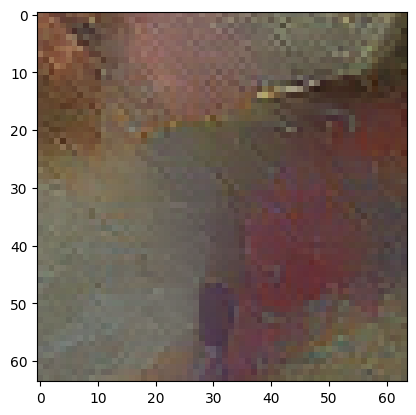

In [24]:
# Project embedding to match UNet's expected input size (1024)
projected_embedding = embedding_projector(text_embedding).unsqueeze(1)  # Shape: (1, 1, 1024)

# Generate noise in latent space
latents = torch.randn(1, 4, 8, 8).to("cuda")  # Random noise

# Generate emoji using UNet
timesteps = torch.tensor([500], device="cuda").long()
with torch.no_grad():
    denoised_latents = unet(latents, timesteps, encoder_hidden_states=projected_embedding).sample

# Decode latents to image
denoised_latents = denoised_latents / 0.18215
with torch.no_grad():
    decoded_image = vae.decode(denoised_latents).sample

# Convert to PIL Image
decoded_image = (decoded_image.clamp(-1, 1) + 1) / 2
decoded_image = decoded_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
decoded_image = (decoded_image * 255).astype(np.uint8)

emoji_image = Image.fromarray(decoded_image)
#emoji_image.save("generated_emoji.png")  # Save the generated emoji
print(f"Generated emoji for: '{text_description}' saved!")
plt.imshow(decoded_image)